# Building a Recommender System with Amazon SageMaker Factorization Machines and BlazingText

---

---

## Background

- Recommender systems were a catalyst for ML's popularity (Amazon, Netflix Prize)
- User item matrix factorization is a core methodology
- Factorization machines combine linear prediction with a factorized representation of pairwise feature interaction

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

- SageMaker has a highly scalable factorization machines algorithm built-in

### Amazon SageMaker Factorization Machines

A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks. It is an extension of a linear model that is designed to capture interactions between features within high dimensional sparse datasets economically. Factorization machines are a good choice for tasks dealing with high dimensional sparse datasets, such as click prediction and item recommendation. 

---

## Setup

1. Spin up SageMaker hosted notebook instance in console
2. Add SageMaker IAM policy to this SageMaker notebook to allow S3 read/write access
3. Instantiate S3 bucket (first code cell)
4. Import necessary libraries (second code cell)

In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
base = 'DEMO-loft-recommender'
prefix = 'sagemaker/' + base

role = sagemaker.get_execution_role()

In [2]:
import sagemaker
import os
import pandas as pd
import numpy as np
import boto3
import json
import io
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from scipy.sparse import csr_matrix

---

## Data

[Amazon Reviews AWS Public Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- 1 to 5 star ratings
- 2M+ Amazon customers
- 160K+ digital videos 

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [4]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

Drop some fields that won't be used

In [5]:
df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]

Most users don't rate most movies - Check our long tail

In [6]:
customers = df['customer_id'].value_counts() #value_counts() returns counts of unique values
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles)) #quantile() returns value at the given quantile.
print('products\n', products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


Filter out customers who haven't rated many movies

In [7]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Create a sequential index for customers and movies

In [9]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

In [10]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0]) + customer_index.shape[0]})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,product_title,star_rating,review_date,user,item
0,27072354,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,10463,140451
1,16030865,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-06-20,489,140451
2,44025160,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-05-27,32100,140451
3,18602179,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-12-23,2237,140451
4,14424972,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,32340,140451


Count days since first review (included as a feature to capture trend)

In [11]:
reduced_df['review_date'] = pd.to_datetime(reduced_df['review_date'])
customer_first_date = reduced_df.groupby('customer_id')['review_date'].min().reset_index()
customer_first_date.columns = ['customer_id', 'first_review_date']

In [12]:
reduced_df = reduced_df.merge(customer_first_date)
reduced_df['days_since_first'] = (reduced_df['review_date'] - reduced_df['first_review_date']).dt.days
reduced_df['days_since_first'] = reduced_df['days_since_first'].fillna(0)

Split into train and test datasets

In [13]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

- Factorization machines expects data to look something like:
  - Sparse matrix
  - Target variable is that user's rating for a movie
  - One-hot encoding for users ($N$ features)
  - One-hot encoding for movies ($M$ features)

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|Feature1|Feature2|...|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|20|2.2|...|
|5|1|0|...|0|0|1|0|...|0|17|9.1|...|
|3|0|1|...|0|1|0|0|...|0|3|11.0|...|
|4|0|1|...|0|0|0|1|...|0|15|6.4|...|


- Wouldn't want to hold this full matrix in memory
  - Create a sparse matrix
  - Designed to work efficiently with CPUs. Some parts of training for more dense matrices can be parallelized with GPUs

In [14]:
def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items + 1
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                           df['days_since_first'].values])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim - 1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [15]:
train_csr = to_csr_matrix(train_df, customer_index.shape[0], product_index.shape[0])
test_csr = to_csr_matrix(test_df, customer_index.shape[0], product_index.shape[0])

Convert to sparse recordIO-wrapped protobuf that SageMaker factorization machines expects

In [16]:
def to_s3_protobuf(csr, label, bucket, prefix, channel='train', splits=10):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)
        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))

In [17]:
to_s3_protobuf(train_csr, train_df['star_rating'].values.astype(np.float32), bucket, prefix)
to_s3_protobuf(test_csr, test_df['star_rating'].values.astype(np.float32), bucket, prefix, channel='test', splits=1)

---

## Train

- Create a [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) estimator to run a training jobs and specify:
  - Algorithm container image
  - IAM role
  - Hardware setup
  - S3 output location
  - Algorithm hyperparameters
    - `feature_dim`: $N + M + 1$ (additional feature is `days_since_first` to capture trend)
    - `num_factors`: number of enitity to use for the decision. Value range: [2,1000]
    - `epochs`: number of full passes through the dataset
- `.fit()` points to training and test data in S3 and begins the training job

- Benefits of using SageMaker's training service:
    - Distributed training
    - Taking advantage of serverless
    - Billed per second
    - Once the training is done - SageMaker will take down the instances for you

In [18]:
fm = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'factorization-machines', 'latest'),
    role, 
    train_instance_count=4, 
    train_instance_type='ml.c5.2xlarge', #If you don't have access to C5, use 'ml.m4.2xlarge' instead.
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    base_job_name=base,
    sagemaker_session=sess)

fm.set_hyperparameters(
    feature_dim=customer_index.shape[0] + product_index.shape[0] + 1,
    predictor_type='regressor',
    mini_batch_size=1000,
    num_factors=256,
    epochs=3)

fm.fit({'train': sagemaker.s3_input('s3://{}/{}/train/'.format(bucket, prefix), distribution='ShardedByS3Key'), 
        'test': sagemaker.s3_input('s3://{}/{}/test/'.format(bucket, prefix), distribution='FullyReplicated')})

INFO:sagemaker:Creating training-job with name: DEMO-loft-recommender-2019-05-10-21-36-51-728


2019-05-10 21:36:52 Starting - Starting the training job...
2019-05-10 21:36:53 Starting - Launching requested ML instances......
2019-05-10 21:38:01 Starting - Preparing the instances for training......
2019-05-10 21:39:15 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[05/10/2019 21:39:34 INFO 140382385235776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'batch_metrics_publish_interval': u'500', u'bias_


2019-05-10 21:39:34 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[05/10/2019 21:39:35 INFO 139909831624512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'batch_metrics_publish_interval': u'500', u'bias_init_sigma': u'0.01', u'_num_gpus': u'auto', u'_data_format': u'record', u'factors_wd': u'0.00001', u'linear_wd': u'0.001', u'_kvstore': u'auto', u'_learning_rate': u'1.0', u'

[2019-05-10 21:39:48.525] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 6, "duration": 3289, "num_examples": 206, "num_bytes": 14630020}
[05/10/2019 21:39:48 INFO 140382385235776] #quality_metric: host=algo-3, epoch=2, train rmse <loss>=1.19724005651
[05/10/2019 21:39:48 INFO 140382385235776] #quality_metric: host=algo-3, train rmse <loss>=1.19724005651
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3292.257070541382, "sum": 3292.257070541382, "min": 3292.257070541382}}, "EndTime": 1557524388.526786, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1557524385.23405}

[05/10/2019 21:39:48 INFO 140382385235776] #progress_metric: host=algo-3, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 206, "sum": 206.0, "min": 206}, "Number of Batches Since Last Reset": {"count": 1, "max": 206, "sum": 206.0, "min": 206}, "Number of Recor


2019-05-10 21:40:06 Uploading - Uploading generated training model
2019-05-10 21:40:30 Completed - Training job completed
Billable seconds: 301


---

## Host

Deploy trained model to a real-time production endpoint

In [19]:
fm_predictor = fm.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

INFO:sagemaker:Creating model with name: factorization-machines-2019-05-10-21-42-26-157
INFO:sagemaker:Creating endpoint with name DEMO-loft-recommender-2019-05-10-21-36-51-728


---------------------------------------------------------------------------------------!

Setup predictor to serialize in-memory data for invocation requests

In [20]:
def fm_serializer(df):
    feature_dim = customer_index.shape[0] + product_index.shape[0] + 1
    js = {'instances': []}
    for index, data in df.iterrows():
        js['instances'].append({'data': {'features': {'values': [1, 1, data['days_since_first']],
                                                      'keys': [data['user'], data['item'], feature_dim - 1],
                                                      'shape': [feature_dim]}}})
    return json.dumps(js)

In [21]:
fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

Real-time prediction for a single user item

In [22]:
test_df.head(1)

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first
0,10378,B002PZDM9Y,Ghosts of Girlfriends Past,4,2013-01-14,8644,174693,2012-12-28,17.0


In [23]:
fm_predictor.predict(test_df.head(1))

{'predictions': [{'score': 1.441070556640625}]}

Clean-up the endpoint

In [24]:
fm_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: DEMO-loft-recommender-2019-05-10-21-36-51-728
INFO:sagemaker:Deleting endpoint with name: DEMO-loft-recommender-2019-05-10-21-36-51-728


---

---

# Extra credit

- What happens when a new movie is added?
  - No feature to set to "1" in the dataset
  - No previous ratings to find similar items
  - Cold start problem is hard with factorization machines
- Word2vec
  - Word embeddings for natural language processing (similar words get similar vectors)
  - Use concatenated product titles as words customer review history as sentences
  - SageMaker BlazingText is an extremely fast implementation that can work with subwords

### Amazon SageMaker BlazingText

The Amazon SageMaker BlazingText algorithm provides highly optimized implementations of the Word2vec and text classification algorithms. The Word2vec algorithm is useful for many downstream natural language processing (NLP) tasks, such as sentiment analysis, named entity recognition, machine translation, etc. Text classification is an important task for applications that perform web searches, information retrieval, ranking, and document classification.

The Word2vec algorithm maps words to high-quality distributed vectors. The resulting vector representation of a word is called a word embedding. Words that are semantically similar correspond to vectors that are close together. That way, word embeddings capture the semantic relationships between words. 

---

## Data

Concatenate product titles to treat each one as a single word

In [25]:
reduced_df['product_title'] = reduced_df['product_title'].apply(lambda x: x.lower().replace(' ', '-'))

Write customer purchase histories

In [28]:
first = True
with open('customer_purchases.txt', 'w') as f:
    for customer, data in reduced_df.sort_values(['customer_id', 'review_date']).groupby('customer_id'):
        if first:
            first = False
        else:
            f.write('\n')
        f.write(' '.join(data['product_title'].tolist()))

Write to S3 so SageMaker training can use it

In [29]:
inputs = sess.upload_data('customer_purchases.txt', bucket, '{}/word2vec/train'.format(prefix))

---

## Train

Create a SageMaker estimator:
- Specify training job arguments
- Set hyperparameters
  - Remove titles that occur less than 5 times
  - Embed in a 100-dimensional subspace
  - Use subwords to capture similarity in titles
  - Learning rate: the step size used for parameter updates.

In [31]:
bt = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'blazingtext', 'latest'),
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p3.2xlarge',
    train_volume_size = 5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess)

bt.set_hyperparameters(mode="skipgram",
    epochs=10,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    min_char=5,
    max_char=10,
    evaluation=False,
    subwords=True)

bt.fit({'train': sagemaker.s3_input(inputs, distribution='FullyReplicated', content_type='text/plain')})

INFO:sagemaker:Creating training-job with name: blazingtext-2019-05-10-22-59-04-994


2019-05-10 22:59:05 Starting - Starting the training job...
2019-05-10 22:59:17 Starting - Launching requested ML instances.........
2019-05-10 23:00:49 Starting - Preparing the instances for training......
2019-05-10 23:02:02 Downloading - Downloading input data
2019-05-10 23:02:02 Training - Training image download completed. Training in progress..
Arguments: train
[05/10/2019 23:02:03 WARNING 140153698400064] Loggers have already been setup.
[05/10/2019 23:02:03 WARNING 140153698400064] Loggers have already been setup.
[05/10/2019 23:02:03 INFO 140153698400064] nvidia-smi took: 0.050320148468 secs to identify 1 gpus
[05/10/2019 23:02:03 INFO 140153698400064] Running BlazingText on singe GPU using skipgram
[05/10/2019 23:02:03 INFO 140153698400064] Processing /opt/ml/input/data/train/customer_purchases.txt . File size: 23 MB
Read 1M words
Number of words:  17990
Initialized GPU 0 successfully! Now starting training....
##### Alpha: 0.0489  Progress: 2.11%  Million Words/sec: 0.55 ###

---

## Model

- Bring in and extract the model from S3
- Take a look at the embeddings

In [32]:
!aws s3 cp $bt.model_data ./

download: s3://sagemaker-us-west-2-601091450883/sagemaker/DEMO-loft-recommender/output/blazingtext-2019-05-10-22-59-04-994/output/model.tar.gz to ./model.tar.gz


In [33]:
!tar -xvzf model.tar.gz

vectors.bin
vectors.txt


In [34]:
vectors = pd.read_csv('vectors.txt', delimiter=' ', skiprows=2, header=None)

Do the embeddings appear to have meaning

In [35]:
vectors.sort_values(1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
3606,spy-kids-2,-1.06810,-0.024672,-0.218780,-0.097573,0.420680,-0.151450,0.337110,0.417000,-0.343550,...,0.448500,-0.123130,0.192430,0.369620,-0.023087,-0.074274,-0.371770,-0.635100,-0.331780,NaN
1593,how-i-met-your-mother-season-1,-1.01600,0.262700,0.184810,-0.208340,0.540450,0.381170,-0.286390,-0.199590,0.009397,...,-0.676850,-0.482320,-1.073700,0.053289,0.555020,0.306170,0.639810,-0.804610,0.386330,NaN
3091,how-i-met-your-mother-season-3,-1.01060,0.223520,0.174040,-0.320040,0.469670,0.314570,-0.351710,-0.243590,0.158710,...,-0.739850,-0.358400,-1.103700,-0.017879,0.489590,0.415580,0.644300,-0.805110,0.433820,NaN
881,how-i-met-your-mother-season-9,-1.00660,0.194120,0.205570,-0.248520,0.381680,0.306700,-0.390410,-0.339140,0.168100,...,-0.846340,-0.298730,-0.958210,0.013262,0.616030,0.338360,0.763570,-0.922010,0.435650,NaN
9235,caribbean,-1.00640,0.432120,0.482240,-0.148380,0.115240,-0.372700,0.720130,0.016261,0.607220,...,0.323530,-0.262440,-0.068901,0.279050,-0.017517,-0.126640,-0.232580,0.169890,-0.030562,NaN
4455,how-i-met-your-mother-season-5,-0.98009,0.204010,0.192460,-0.323870,0.470910,0.368740,-0.343030,-0.203340,0.159230,...,-0.828770,-0.405640,-1.059700,0.075353,0.504420,0.414590,0.722950,-0.892820,0.425880,NaN
2112,spy-kids,-0.96580,-0.273990,0.042230,-0.228270,0.646750,-0.182460,0.120060,0.412480,-0.229470,...,0.640280,-0.047672,-0.100540,0.484540,0.035468,0.474250,-0.220670,-0.754620,-0.539180,NaN
3779,how-i-met-your-mother-season-7,-0.96366,0.218980,0.190170,-0.288910,0.473230,0.401340,-0.375000,-0.299230,0.172910,...,-0.807250,-0.342160,-1.004400,0.048629,0.479500,0.413200,0.715370,-0.886630,0.361020,NaN
5087,how-i-met-your-mother-season-6,-0.96151,0.229670,0.184410,-0.288030,0.532510,0.391340,-0.383580,-0.257560,0.215580,...,-0.805840,-0.347110,-1.129700,0.075206,0.503100,0.437730,0.703420,-0.838770,0.345050,NaN
1414,how-i-met-your-mother-season-8,-0.96097,0.269950,0.205590,-0.303250,0.400680,0.337150,-0.385360,-0.305680,0.158380,...,-0.849550,-0.292650,-1.082800,-0.029076,0.593640,0.370560,0.703640,-0.816990,0.436370,NaN


In [36]:
vectors.sort_values(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
659,the-good-lie,0.455400,-1.25660,0.392850,0.026171,0.257710,-0.020867,0.503310,-0.556400,0.585410,...,-0.341160,-0.014311,-0.129680,-0.147940,-0.158280,0.375390,-0.551630,-0.191690,-0.379590,NaN
1264,when-the-game-stands-tall,0.004605,-1.22020,0.081590,0.551890,0.283510,-0.063281,-0.116400,-0.653800,-0.006811,...,-0.082479,-0.037519,-0.074339,0.139190,-0.153980,0.328660,-0.184960,-0.691800,0.163460,NaN
615,penguins-of-madagascar,0.095611,-1.14650,0.263070,0.159970,0.457840,0.123250,0.051977,0.211650,-0.254730,...,0.091272,-0.138580,0.227440,0.051897,-0.321520,0.598420,-0.459790,-0.621760,-0.109210,NaN
1668,top-five,0.442180,-1.14140,0.313970,0.372770,-0.042505,0.065923,0.117850,-0.614460,0.146920,...,-0.028981,-0.277350,0.399840,-0.270110,-0.038126,0.659170,-0.048008,-0.372890,0.066751,NaN
1498,white-collar-season-4,0.065421,-1.07620,-0.241440,0.406800,0.387650,-0.415370,-0.092015,0.245310,0.053095,...,-0.299750,-0.443950,-0.083287,0.011451,0.294870,0.772330,-0.427750,0.049302,0.204480,NaN
1145,white-collar-season-5,0.026774,-1.05130,-0.177740,0.456580,0.349890,-0.297380,-0.124440,0.311430,0.127690,...,-0.367880,-0.452140,0.029664,0.056823,0.333630,0.843990,-0.444600,-0.095617,0.157700,NaN
168,the-hundred-foot-journey-(theatrical),0.202900,-1.02950,-0.083051,0.135200,-0.176450,-0.022385,0.155780,-0.116120,0.196370,...,0.300000,-0.055860,0.121130,-0.343770,0.531410,0.437690,-0.389820,-0.431480,-0.208860,NaN
1598,arthur-christmas,-0.002289,-1.02730,0.171460,-0.078443,-0.354910,-0.708470,0.029760,0.040890,-0.471730,...,0.101320,-0.478400,-0.413110,0.036449,-0.135000,0.620230,-0.137790,-0.362000,0.471780,NaN
6916,this-christmas,0.042864,-1.01860,0.288310,0.106090,-0.069415,-1.302800,0.182520,0.066308,0.154950,...,0.187960,0.306860,0.173850,-0.183360,-0.529760,0.274700,-0.663020,-0.844160,0.271720,NaN
1553,white-collar-season-6,0.087467,-1.01780,-0.190100,0.525940,0.458960,-0.266890,-0.202030,0.217470,0.264320,...,-0.339300,-0.333660,-0.078445,0.058682,0.299390,0.941650,-0.470970,-0.023862,0.033288,NaN


Yes, but there's 100.  Let's reduce this further with t-SNE and map the top 100 titles.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. 

In [37]:
product_titles = vectors[0]
vectors = vectors.drop([0, 101], axis=1)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
embeddings = tsne.fit_transform(vectors.values[:100, ])

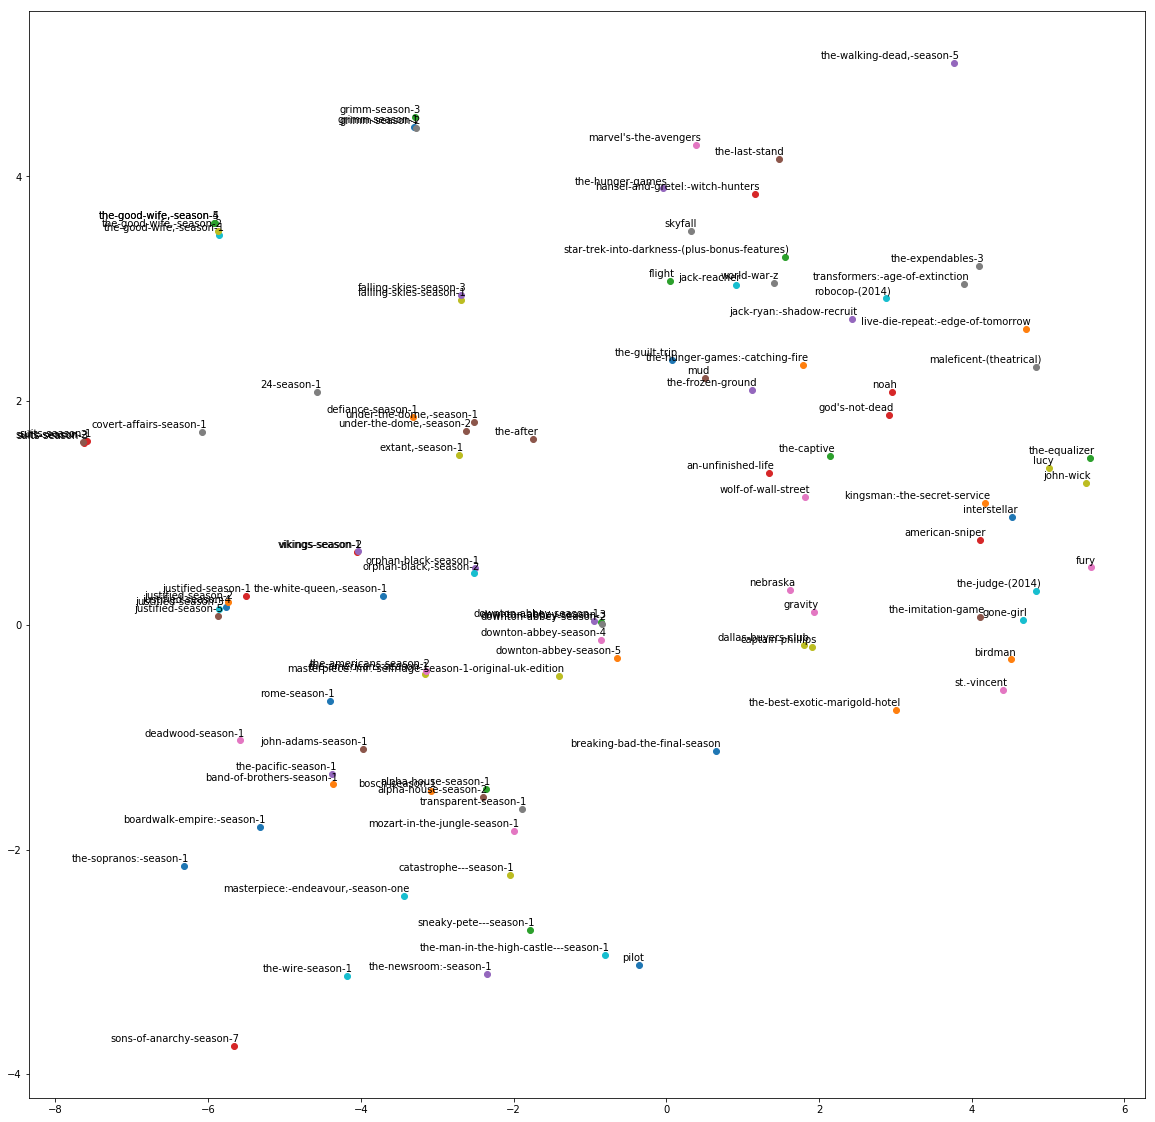

In [39]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(embeddings, product_titles[:100])

---

## Host

Deploy our model to a real-time endpoint.

In [40]:
bt_endpoint = bt.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-05-10-23-06-19-439
INFO:sagemaker:Creating endpoint with name blazingtext-2019-05-10-22-59-04-994


---------------------------------------------------------------------------------------------------!

Try generating predictions for a set of titles (some of which are real, some of which are made up).

In [41]:
words = ["sherlock-season-1", 
         "sherlock-season-2",
         "sherlock-season-5",
         'arbitrary-sherlock-holmes-string',
         'the-imitation-game',
         "abcdefghijklmn",
         "keeping-up-with-the-kardashians-season-1"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs_df = pd.DataFrame(json.loads(response))

Calculate correlation and distance.

In [42]:
vecs_df = pd.DataFrame(vecs_df['vector'].values.tolist(), index=vecs_df['word'])

In [43]:
vecs_df = vecs_df.transpose()
vecs_df.corr()

word,sherlock-season-1,sherlock-season-2,sherlock-season-5,arbitrary-sherlock-holmes-string,the-imitation-game,abcdefghijklmn,keeping-up-with-the-kardashians-season-1
word,,,,,,,
sherlock-season-1,1.000000,0.970297,0.937833,0.589454,0.292658,0.193802,0.164093
sherlock-season-2,0.970297,1.000000,0.947738,0.582496,0.257141,0.192486,0.181542
sherlock-season-5,0.937833,0.947738,1.000000,0.598044,0.322659,0.209299,0.220179
arbitrary-sherlock-holmes-string,0.589454,0.582496,0.598044,1.000000,0.369759,0.144254,0.054129
the-imitation-game,0.292658,0.257141,0.322659,0.369759,1.000000,0.361088,0.192964
abcdefghijklmn,0.193802,0.192486,0.209299,0.144254,0.361088,1.000000,0.353785
keeping-up-with-the-kardashians-season-1,0.164093,0.181542,0.220179,0.054129,0.192964,0.353785,1.000000


In [44]:
for column in vecs_df.columns:
    print(column + ':', np.sum((vecs_df[column] - vecs_df['sherlock-season-1']) ** 2))

sherlock-season-1: 0.0
sherlock-season-2: 0.7451682617643147
sherlock-season-5: 1.513802848105048
arbitrary-sherlock-holmes-string: 8.63801999382471
the-imitation-game: 13.825652283518245
abcdefghijklmn: 12.160871233517181
keeping-up-with-the-kardashians-season-1: 20.400424056063457


Relative to 'sherlock-season-1':
- 'sherlock-season-5' is made up, but relates well with 'sherlock-season-1' and 'sherlock-season-2'
- 'arbitrary-sherlock-holmes-string' is also made up and relates less well but still fairly strong
- 'the-imitation-game' is another popular Prime video title starring Benedict Cumberbatch and has a moderate relationship, but worse than the arbitrary Sherlock title
- 'abcdefghijklmn' is made up and relates even worse
- 'keeping-up-with-the-kardashians-season-1' somehow manages to relate even worse

Clean-up the endpoint

In [ ]:
bt_endpoint.delete_endpoint()

---
## **Stop the notebook instance!**
---

# Wrap-up

- Built a recommender system on a large dataset quickly and accurately
- Add more features to extend
- Compare to other methods
- Ensemble two models